In [93]:
import pandas as pd
from datetime import datetime, date, time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import joblib

In [2]:
all_data = pd.read_excel("sample.xlsx")

In [3]:
all_data.columns

Index(['Mark', 'Qflow', 'Arrival to secretaries', 'nurse station',
       'scheduled nurse visit time', 'addmitance to nurse time', 'doctor',
       'scheduled doctor visit time', 'addmitance to doctor time',
       'requires blood test'],
      dtype='object')

In [102]:
all_data.head()

,Mark,Qflow,Arrival to secretaries,nurse station,scheduled nurse visit time,addmitance to nurse time,doctor,scheduled doctor visit time,addmitance to doctor time,requires blood test
0,A001,09:30:00,09:37:00,5,09:40:00,09:42:00,Leukemia 1,12:00:00,11:42:00,y
1,A002,09:25:00,09:27:00,1,09:20:00,09:36:00,Leukemia 1,11:30:00,11:08:00,y
2,A003,08:31:00,08:38:00,1,08:40:00,08:43:00,Leukemia 1,13:30:00,12:55:00,n
3,A004,09:10:00,09:17:00,5,09:00:00,09:30:00,Leukemia 1,11:00:00,11:24:00,y
4,A005,08:45:00,08:50:00,4,08:40:00,09:12:00,Leukemia 1,09:50:00,NaN,n


### QFlow analysis

In [4]:
Qflow_data = all_data[['Qflow', 'Arrival to secretaries']]

In [5]:
Qflow_data.head()

,Qflow,Arrival to secretaries
0,09:30:00,09:37:00
1,09:25:00,09:27:00
2,08:31:00,08:38:00
3,09:10:00,09:17:00
4,08:45:00,08:50:00


In [6]:
#sort by Qflow
Qflow_data = Qflow_data.sort_values(by='Qflow')


In [7]:
Qflow_data

,Qflow,Arrival to secretaries
23,07:23:00,08:02:00
27,07:44:00,08:02:00
26,08:17:00,08:20:00
9,08:27:00,08:37:00
2,08:31:00,08:38:00
4,08:45:00,08:50:00
22,08:50:00,08:54:00
8,08:50:00,08:55:00
3,09:10:00,09:17:00
11,09:13:00,09:17:00


### Seems like secretaries start working at 08:00 so we will only consider arrivals after 08:00 when analyzing secretary service durations

In [8]:
arrival_cutoff = datetime.strptime('08:00:00', '%H:%M:%S').time()
arrival_filter = Qflow_data['Qflow'] > arrival_cutoff

In [9]:
valid_Qflow_data = Qflow_data[arrival_filter]
valid_Qflow_data

,Qflow,Arrival to secretaries
26,08:17:00,08:20:00
9,08:27:00,08:37:00
2,08:31:00,08:38:00
4,08:45:00,08:50:00
22,08:50:00,08:54:00
8,08:50:00,08:55:00
3,09:10:00,09:17:00
11,09:13:00,09:17:00
25,09:23:00,09:25:00
1,09:25:00,09:27:00


In [38]:
# Function to convert time to datetime


def time_to_datetime(obj):
    if isinstance(obj, datetime):
        # If it's already a datetime, return it as is
        return obj
    elif isinstance(obj, time):
        # If it's a time, combine with today's date
        return datetime.combine(date.today(), obj)
    else:
        raise TypeError("Expected a datetime or time object")

# Apply the conversion function to both columns
valid_Qflow_data['Arrival to secretaries'] = valid_Qflow_data['Arrival to secretaries'].apply(time_to_datetime)
valid_Qflow_data['Qflow'] = valid_Qflow_data['Qflow'].apply(time_to_datetime)

# Calculate the duration
valid_Qflow_data['secretary_service_duration'] = valid_Qflow_data['Arrival to secretaries'] - valid_Qflow_data['Qflow']
valid_Qflow_data['secretary_service_duration'] = valid_Qflow_data['secretary_service_duration'].apply(lambda x: int(x.total_seconds() / 60))
valid_Qflow_data

C:\Users\Yoni\AppData\Local\Temp\ipykernel_18376\1517832809.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_Qflow_data['Arrival to secretaries'] = valid_Qflow_data['Arrival to secretaries'].apply(time_to_datetime)
C:\Users\Yoni\AppData\Local\Temp\ipykernel_18376\1517832809.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_Qflow_data['Qflow'] = valid_Qflow_data['Qflow'].apply(time_to_datetime)
C:\Users\Yoni\AppData\Local\Temp\ipykernel_18376\1517832809.py:19: SettingWithCopyWarning: 
A va

,Qflow,Arrival to secretaries,secretary_service_duration
26,2025-06-07 08:17:00,2025-06-07 08:20:00,3
9,2025-06-07 08:27:00,2025-06-07 08:37:00,10
2,2025-06-07 08:31:00,2025-06-07 08:38:00,7
4,2025-06-07 08:45:00,2025-06-07 08:50:00,5
22,2025-06-07 08:50:00,2025-06-07 08:54:00,4
8,2025-06-07 08:50:00,2025-06-07 08:55:00,5
3,2025-06-07 09:10:00,2025-06-07 09:17:00,7
11,2025-06-07 09:13:00,2025-06-07 09:17:00,4
25,2025-06-07 09:23:00,2025-06-07 09:25:00,2
1,2025-06-07 09:25:00,2025-06-07 09:27:00,2


In [41]:
more_data = pd.read_excel('sample_einav.xlsx')

more_data.head()

,Qflow,Arrival to secretaries,secretary_service_duration
0,08:21:00,08:38:00,00:17:00
1,08:26:00,08:39:00,00:13:00
2,08:33:00,08:40:00,00:07:00
3,08:34:00,08:42:00,00:08:00
4,08:41:00,08:48:00,00:07:00


In [44]:
# Apply the conversion function to both columns
more_data['Arrival to secretaries'] = more_data['Arrival to secretaries'].apply(time_to_datetime)
more_data['Qflow'] = more_data['Qflow'].apply(time_to_datetime)

# Calculate the duration
more_data['secretary_service_duration'] = more_data['Arrival to secretaries'] - more_data['Qflow']
more_data['secretary_service_duration'] = more_data['secretary_service_duration'].apply(lambda x: int(x.total_seconds() / 60))
more_data

,Qflow,Arrival to secretaries,secretary_service_duration
0,2025-06-07 08:21:00,2025-06-07 08:38:00,17
1,2025-06-07 08:26:00,2025-06-07 08:39:00,13
2,2025-06-07 08:33:00,2025-06-07 08:40:00,7
3,2025-06-07 08:34:00,2025-06-07 08:42:00,8
4,2025-06-07 08:41:00,2025-06-07 08:48:00,7
5,2025-06-07 08:43:00,2025-06-07 08:53:00,10
6,2025-06-07 08:51:00,2025-06-07 08:56:00,5
7,2025-06-07 08:52:00,2025-06-07 08:59:00,7
8,2025-06-07 08:56:00,2025-06-07 09:00:00,4
9,2025-06-07 08:57:00,2025-06-07 09:04:00,7


In [48]:
sample = np.concatenate([
    valid_Qflow_data['secretary_service_duration'].to_numpy(),
    more_data['secretary_service_duration'].to_numpy()
])


In [50]:
sample

array([ 3, 10,  7,  5,  4,  5,  7,  4,  2,  2,  7,  4,  3,  3,  2,  5, 12,
        1,  8,  3,  0,  5,  2, 17, 13,  7,  8,  7, 10,  5,  7,  4,  7,  5,
        6, 12, 13,  2,  5], dtype=int64)

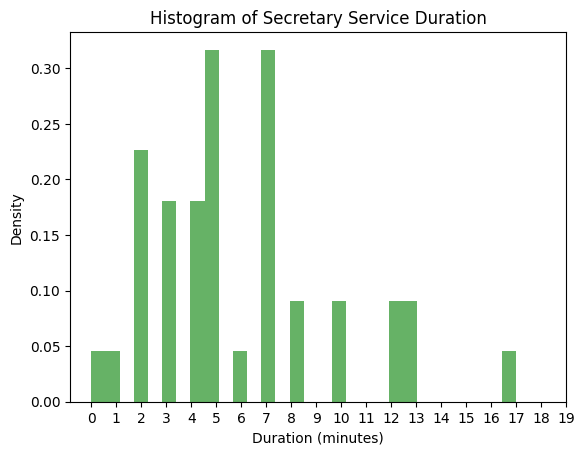

In [55]:
# Plot a histogram of the data
plt.hist(sample, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.xticks(range(0, 20, 1))
plt.title('Histogram of Secretary Service Duration')
plt.show()

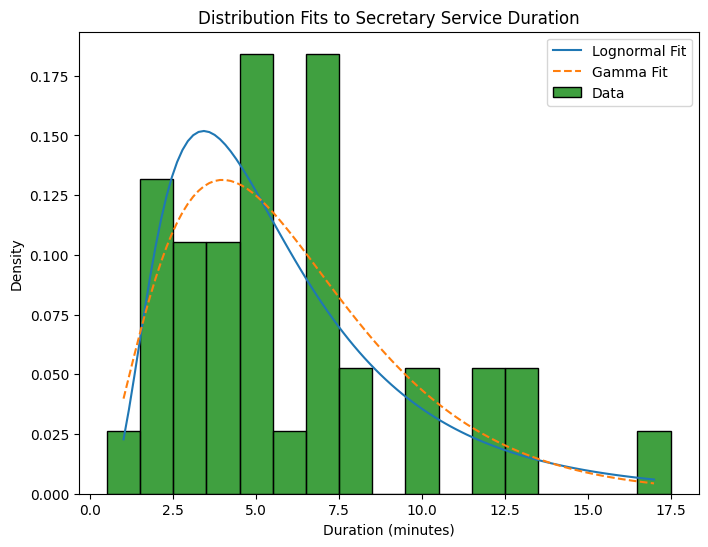

In [63]:
sample = sample[sample > 0]
# Fit distributions
params_lognorm = stats.lognorm.fit(sample, floc=0)
params_gamma = stats.gamma.fit(sample, floc=0)

# Plot the fits
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(sample, kde=False, stat='density', discrete=True, color='green', ax=ax, label='Data')

x = np.arange(min(sample), max(sample)+1)

# Lognormal and Gamma (if continuous approximation acceptable)
x_continuous = np.linspace(min(sample), max(sample), 100)

lognorm_pdf = stats.lognorm.pdf(x_continuous, *params_lognorm)
ax.plot(x_continuous, lognorm_pdf, '-', label='Lognormal Fit')

gamma_pdf = stats.gamma.pdf(x_continuous, *params_gamma)
ax.plot(x_continuous, gamma_pdf, '--', label='Gamma Fit')

ax.legend()
ax.set_title("Distribution Fits to Secretary Service Duration")
ax.set_xlabel("Duration (minutes)")
ax.set_ylabel("Density")
plt.show()


In [90]:
sample_2 = sample.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=1.1).fit(sample_2)
kde.score_samples(sample_2)

array([-2.2078084 , -3.55794125, -2.30273204, -2.11931045, -2.11636292,
       -2.11931045, -2.30273204, -2.11636292, -2.42775916, -2.42775916,
       -2.30273204, -2.11636292, -2.2078084 , -2.2078084 , -2.42775916,
       -2.11931045, -3.34108054, -3.00702322, -2.65263314, -2.2078084 ,
       -2.11931045, -2.42775916, -4.64908398, -3.43604485, -2.30273204,
       -2.65263314, -2.30273204, -3.55794125, -2.11931045, -2.30273204,
       -2.11636292, -2.30273204, -2.11931045, -2.20804065, -3.34108054,
       -3.43604485, -2.42775916, -2.11931045])

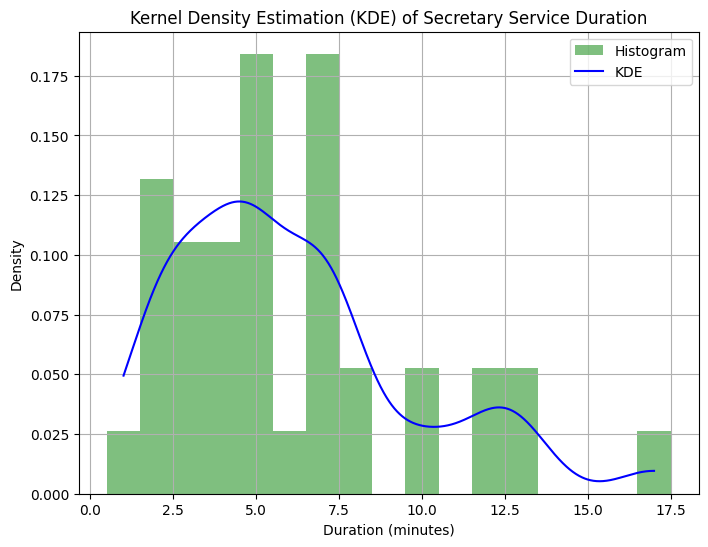

In [91]:
x_plot = np.linspace(sample.min(), sample.max(), 1000).reshape(-1, 1)
log_density_plot = kde.score_samples(x_plot)
density_plot = np.exp(log_density_plot)

plt.figure(figsize=(8, 6))
plt.hist(sample.flatten(), bins=np.arange(sample.min(), sample.max()+2)-0.5,
         density=True, alpha=0.5, color='green', label='Histogram')
plt.plot(x_plot, density_plot, color='blue', label='KDE')
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.title("Kernel Density Estimation (KDE) of Secretary Service Duration")
plt.legend()
plt.grid(True)
plt.show()

### I arrived at the selected bandwith and kernel using visual inspection. If time allows, we will deploy more advanced methods.

In [97]:
import os

os.makedirs("statistical_distributions", exist_ok=True)

joblib.dump(kde, "statistical_distributions/secretary_service_kde.joblib")

['statistical_distributions/secretary_service_kde.joblib']

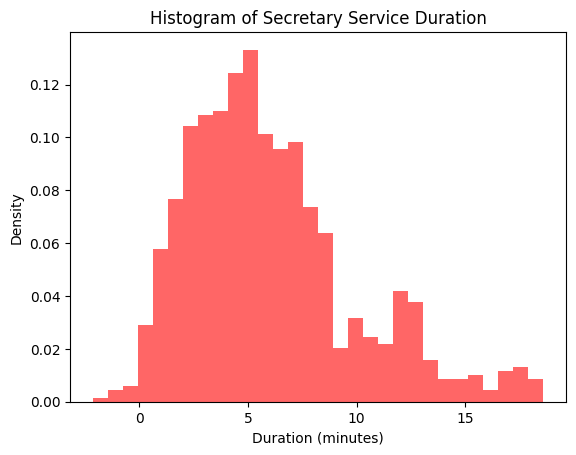

In [101]:
# Load
kde_loaded = joblib.load("statistical_distributions/secretary_service_kde.joblib")

# Sample from it
samples = kde_loaded.sample(1000).flatten()

#plot the histogram of the samples

plt.hist(samples, bins=30, density=True, alpha=0.6, color='r')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.title('Histogram of Secretary Service Duration')
plt.show()

### Analyzing the data per patient type

In [109]:
leukemia = all_data[all_data['doctor'].str.contains('Leukemia')]
transplant = all_data[all_data['doctor'].str.contains('Transplant')]




In [116]:
leukemia

,Mark,Qflow,Arrival to secretaries,nurse station,scheduled nurse visit time,addmitance to nurse time,doctor,scheduled doctor visit time,addmitance to doctor time,requires blood test
0,A001,09:30:00,09:37:00,5,09:40:00,09:42:00,Leukemia 1,12:00:00,11:42:00,y
1,A002,09:25:00,09:27:00,1,09:20:00,09:36:00,Leukemia 1,11:30:00,11:08:00,y
2,A003,08:31:00,08:38:00,1,08:40:00,08:43:00,Leukemia 1,13:30:00,12:55:00,n
3,A004,09:10:00,09:17:00,5,09:00:00,09:30:00,Leukemia 1,11:00:00,11:24:00,y
4,A005,08:45:00,08:50:00,4,08:40:00,09:12:00,Leukemia 1,09:50:00,NaN,n
5,A006,09:48:00,09:50:00,1,10:00:00,09:55:00,Leukemia 1,11:00:00,12:15:00,y
6,A007,12:14:00,12:19:00,0,NaN,NaN,Leukemia 1,12:30:00,12:55:00,n
7,A008,09:38:00,09:41:00,0,NaN,NaN,Leukemia 1,09:20:00,13:08:00,y
8,B001,08:50:00,08:55:00,5,08:00:00,09:03:00,Leukemia 2,10:00:00,11:27:00,n
9,B002,08:27:00,08:37:00,5,08:20:00,08:49:00,Leukemia 2,09:00:00,10:21:00,n


In [123]:
transplant

,Mark,Qflow,Arrival to secretaries,nurse station,scheduled nurse visit time,addmitance to nurse time,doctor,scheduled doctor visit time,addmitance to doctor time,requires blood test
13,C001,10:51:00,10:59:00,5,11:00:00,11:21:00,Transplant 1,12:20:00,13:16:00,0
14,C002,10:05:00,10:17:00,0,NaN,NaN,Transplant 1,10:30:00,11:43:00,0
15,C003,NaN,08:44:00,1,08:00:00,09:09:00,Transplant 1,11:00:00,12:03:00,0
16,D001,11:03:00,11:06:00,5,11:20:00,11:36:00,Transplant 2,14:40:00,NaN,0
17,D002,NaN,10:21:00,3,11:00:00,11:17:00,Transplant 2,12:40:00,12:10:00,0
18,D003,NaN,10:02:00,4,10:50:00,10:02:00,Transplant 2,14:00:00,12:23:00,0
19,D004,09:32:00,09:36:00,6,09:40:00,09:51:00,Transplant 2,11:40:00,11:43:00,0
20,D005,12:13:00,12:13:00,2,12:20:00,13:11:00,Transplant 2,15:00:00,NaN,0
21,D006,13:45:00,13:47:00,4,13:00:00,14:15:00,Transplant 2,14:20:00,NaN,0
22,D007,08:50:00,08:54:00,2,08:00:00,09:08:00,Transplant 2,10:20:00,13:31:00,0


In [118]:
#count na proportion in the scheduled nurse visit time column
proportion_na_scheduled_nurse_visit_time_leukemia = sum(leukemia['scheduled nurse visit time'].isna())/len(leukemia)
proportion_na_scheduled_nurse_visit_time_transplant = sum(transplant['scheduled nurse visit time'].isna())/len(transplant)

print(f'proportion_no_scheduled_nurse_visit_time_leukemia: {proportion_na_scheduled_nurse_visit_time_leukemia}')
print(f'proportion_no_scheduled_nurse_visit_time_transplant: {proportion_na_scheduled_nurse_visit_time_transplant}')

proportion_no_scheduled_nurse_visit_time_leukemia: 0.23076923076923078
proportion_no_scheduled_nurse_visit_time_transplant: 0.06666666666666667


In [119]:
# turn requires blood test into a binary variable from y/n to 1/0
leukemia['requires blood test'] = leukemia['requires blood test'].map({'y': 1, 'n': 0})
transplant['requires blood test'] = transplant['requires blood test'].map({'y': 1, 'n': 0})

proportion_requires_blood_test_leukemia = leukemia['requires blood test'].mean()
proportion_requires_blood_test_transplant = transplant['requires blood test'].mean()

print(f'proportion_requires_blood_test_leukemia: {proportion_requires_blood_test_leukemia}')
print(f'proportion_requires_blood_test_transplant: {proportion_requires_blood_test_transplant}')

proportion_requires_blood_test_leukemia: 0.46153846153846156
proportion_requires_blood_test_transplant: 0.06666666666666667


C:\Users\Yoni\AppData\Local\Temp\ipykernel_18376\3965299016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leukemia['requires blood test'] = leukemia['requires blood test'].map({'y': 1, 'n': 0})
C:\Users\Yoni\AppData\Local\Temp\ipykernel_18376\3965299016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transplant['requires blood test'] = transplant['requires blood test'].map({'y': 1, 'n': 0})


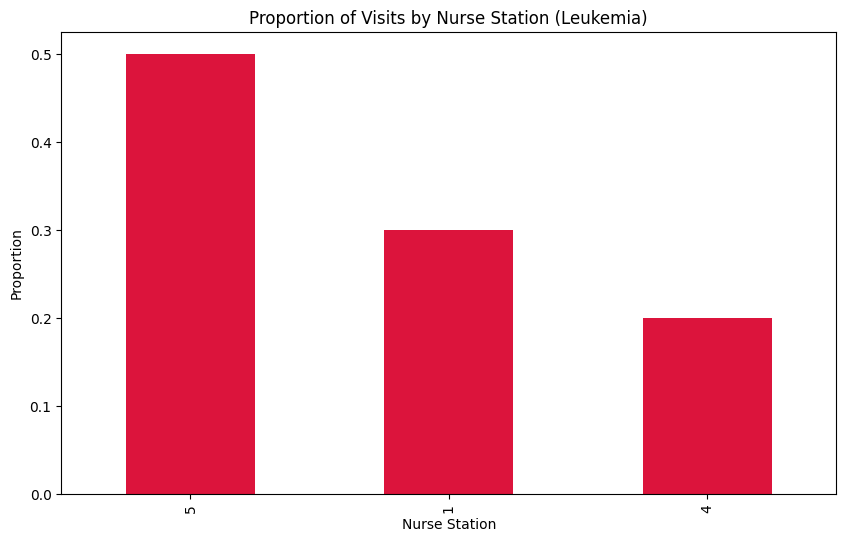

In [141]:
#plot the proportion of each value in the 'nurse station' column given that visited nurse
leukemia_sorted_by_nurse_station = leukemia[leukemia['nurse station'] != 0].sort_values(by='nurse station')
leukemia_nurse_station_counts = leukemia_sorted_by_nurse_station['nurse station'].value_counts()
leukemia_nurse_station_proportions = leukemia_nurse_station_counts / leukemia_nurse_station_counts.sum()

# Plot the proportions
plt.figure(figsize=(10, 6))
leukemia_nurse_station_proportions.plot(kind='bar', color='crimson')
plt.title('Proportion of Visits by Nurse Station (Leukemia)')
plt.xlabel('Nurse Station')
plt.ylabel('Proportion')
plt.show()

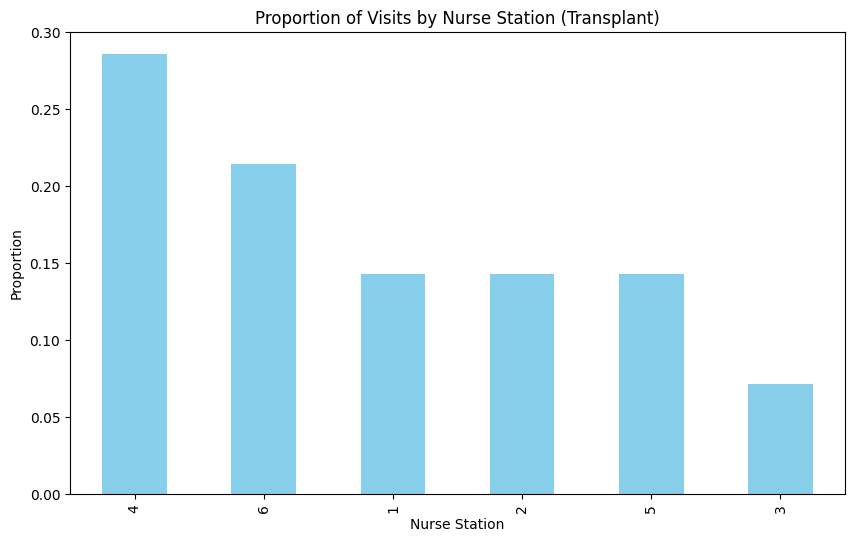

In [142]:
#plot the proportion of each value in the 'nurse station' column given that visited nurse
transplant_sorted_by_nurse_station = transplant[transplant['nurse station'] != 0].sort_values(by='nurse station')
transplant_nurse_station_counts = transplant_sorted_by_nurse_station['nurse station'].value_counts()
transplant_nurse_station_proportions = transplant_nurse_station_counts / transplant_nurse_station_counts.sum()

# Plot the proportions
plt.figure(figsize=(10, 6))
transplant_nurse_station_proportions.plot(kind='bar', color='skyblue')
plt.title('Proportion of Visits by Nurse Station (Transplant)')
plt.xlabel('Nurse Station')
plt.ylabel('Proportion')
plt.show()

In [143]:
leukemia_nurse_station_counts

nurse station
5    5
1    3
4    2
Name: count, dtype: int64

In [144]:
print('leukemia_nurse_station_counts')
for station, count in leukemia_nurse_station_counts.sort_index().items():
    print(f'proportion in station {station}: {count / leukemia_nurse_station_counts.sum():.2%}')

print('\n')

print('transplant_nurse_station_counts')
for station, count in transplant_nurse_station_counts.sort_index().items():
    print(f'proportion in station {station}: {count / transplant_nurse_station_counts.sum():.2%}')


leukemia_nurse_station_counts
proportion in station 1: 30.00%
proportion in station 4: 20.00%
proportion in station 5: 50.00%


transplant_nurse_station_counts
proportion in station 1: 14.29%
proportion in station 2: 14.29%
proportion in station 3: 7.14%
proportion in station 4: 28.57%
proportion in station 5: 14.29%
proportion in station 6: 21.43%


In [147]:
from scipy.stats import truncnorm

# Parameters
mean = 50
std = 3.33
lower = 20
upper = 80

# Convert bounds to standard normal scale
a, b = (lower - mean) / std, (upper - mean) / std
dist = truncnorm(a, b, loc=mean, scale=std)

# Sample from the distribution
samples = dist.rvs(1000)


(array([ 16.,  41., 103., 180., 208., 190., 147.,  75.,  32.,   8.]),
 array([44.71236517, 45.82015266, 46.92794015, 48.03572763, 49.14351512,
        50.2513026 , 51.35909009, 52.46687758, 53.57466506, 54.68245255,
        55.79024003]),
 <BarContainer object of 10 artists>)

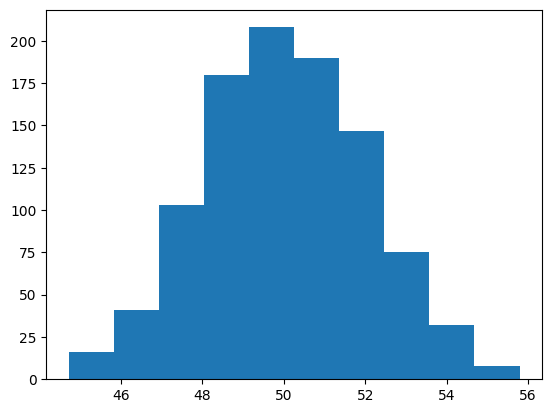

In [149]:
plt.hist(samples)

In [150]:
array = np.array([np.random.exponential(2) for i in range(1000)])

print(np.mean(array))

1.9744661864218183
